<a href="https://colab.research.google.com/github/jadraque94/Image_ISAR/blob/main/BE_NOTE_MARCELIN_JADRAQUE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BE NOTE - MARCELIN THALUL-DE  | JADRAQUE CHADI**

## **Partie I - Analyse de donnees ISAR**

In [309]:
import matplotlib.pyplot as plt
from scipy.spatial import distance
import numpy as np
from PIL import Image
import os
import numpy as np
from skimage.transform import warp_polar, rotate, rescale, resize
from skimage.registration import phase_cross_correlation
from glob import glob
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import geometric_transform
from scipy.ndimage import rotate
import cv2
from sklearn import model_selection
from sklearn import neighbors, metrics
from sklearn.neighbors import KNeighborsClassifier
import time
from  sklearn.metrics import classification_report, confusion_matrix
import scipy.stats


In [310]:
files = glob("images_ISAR/*.bmp") #Get the bmp files of in folder

Dict = {}
print(files)
for f in files:
    fullPic = f.split('/')[1]
    shortPic = fullPic.split('.bmp')[0]
    classPic = shortPic.split('_')[0]
    noPic = shortPic.split('_')[1]
    try:
        Dict[classPic] +=1
    except KeyError as e:
        Dict[classPic] = 1
print(Dict)

{'A10': 162, 'F14': 162, 'F15': 162, 'F16': 162, 'F4': 162}


In [311]:
# Fonction load_bdd pour la creation de la matrice de donnees et de labels
# On utilise les labels 0 1 2 3 4 respectivement pour les cilbles A10 F4 F14 F15 F16

def load_bdd(path):
    images = glob(path + "/*")
    data = np.zeros((len(images),128*128))
    labels = []
    
    dictLabels = {
        'A10': 0,
        'F4' :1,
        'F14': 2,
        'F15' : 3,
        'F16' : 4,
    }
    
    for (i, pth) in enumerate(images):
        img = cv2.imread(pth, cv2.IMREAD_GRAYSCALE) #on utlise cv2.IMREAD_GRAYSCALE pour supprimer le canal multicouleur et avoir une image de taille 255*255
        img = img[64:192,64:192] # On selectionne que les pixels au centre de l'image
        
        data[i] = img.flatten() / 255
        
        pathsplit = os.path.split(pth)  
        labels.append(dictLabels[pathsplit[1].split('_')[0]])
        
    labels = np.array(labels)
    #np.random.shuffle(labels)
    
    return data, labels

In [312]:
# Affichage de la matrice des donnees et des labels

print(load_bdd("images_ISAR/"))

(array([[0.00392157, 0.00392157, 0.00784314, ..., 0.        , 0.00392157,
        0.00392157],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.        , 0.        ,
        0.        ],
       [0.01176471, 0.01176471, 0.01176471, ..., 0.00392157, 0.00392157,
        0.00392157],
       ...,
       [0.00392157, 0.00392157, 0.00392157, ..., 0.        , 0.00392157,
        0.00392157],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00392157, ..., 0.        , 0.        ,
        0.00392157]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## **Partie II -  Extraction de caracteristique - image polaire**

In [313]:
def polaire(img):
    N_r = 50
    N_theta = 50
    R_max = 50
    R_min = 0
    
    x0 = img.shape[0] / 2
    y0 = img.shape[1] / 2

    delta_theta = 2 * np.pi / (N_theta - 1)
    delta_r = (R_max - R_min) / (N_r - 1)

    r_m = np.linspace(R_min, R_max,N_r)
    theta_n = np.linspace(-1 * np.pi, np.pi, N_theta)
 
    r_m, theta_n = np.meshgrid(r_m, theta_n)
    image_polaire = img[np.int8(np.floor(x0 + r_m * np.cos(theta_n))), np.int8(np.floor(y0 + r_m * np.sin(theta_n)))]
    
    return image_polaire

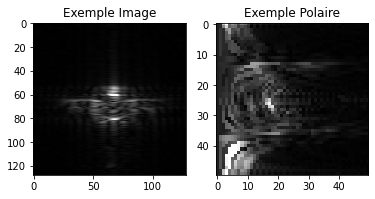

In [314]:
# Affichage Image Polaire

exemple_path = "images_ISAR/F4_1.bmp"
exemple_image = cv2.imread(exemple_path)[64:192,64:192]

plt.subplot(121)
plt.title("Exemple Image")
plt.imshow(exemple_image)

image_polaire = polaire(exemple_image)
plt.subplot(122)
plt.title("Exemple Polaire")
plt.imshow(image_polaire)

plt.show()

In [315]:
# Dimension de la nouvelle image 5 :
print("Dimension: ", image_polaire.shape)

Dimension:  (50, 50, 3)


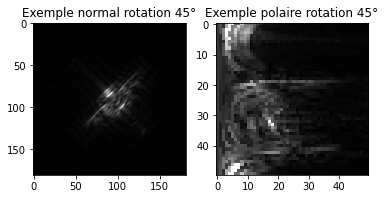

In [316]:
# Rotatation de 45 degree et affichage

rotated_image = rotate(exemple_image, 45)
rotated_polar_image = polaire(rotated_image)

plt.figure()

plt.subplot(121)
plt.imshow(rotated_image)
plt.title("Exemple normal rotation 45°")

plt.subplot(122)
plt.imshow(rotated_polar_image)
plt.title("Exemple polaire rotation 45°")

plt.show()

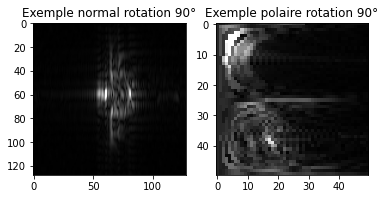

In [317]:
# Rotatation de 90 degree et affichage

rotated_image = rotate(exemple_image, 90)
rotated_polar_image = polaire(rotated_image)

plt.figure()

plt.subplot(121)
plt.imshow(rotated_image)
plt.title("Exemple normal rotation 90°")

plt.subplot(122)
plt.imshow(rotated_polar_image)
plt.title("Exemple polaire rotation 90°")

plt.show()

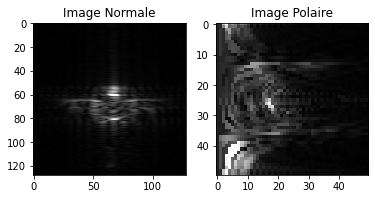

In [318]:
# Changement d'echelle et affichage

resized_image = rescale(exemple_image, 1, multichannel=True)
rezized_image_polaire = polaire(resized_image)

plt.figure()

plt.subplot(121)
plt.imshow(resized_image)
plt.title("Image Normale")

plt.subplot(122)
plt.imshow(rezized_image_polaire)
plt.title("Image Polaire")

plt.show()

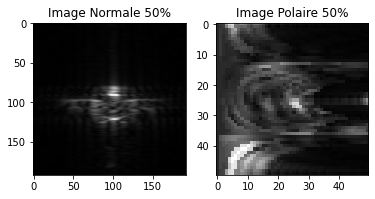

In [319]:
# Changement d'echelle et affichage

resized_image = rescale(exemple_image, 1.5, multichannel=True)
rezized_image_polaire = polaire(resized_image)

plt.figure()

plt.subplot(121)
plt.imshow(resized_image)
plt.title("Image Normale 50%")

plt.subplot(122)
plt.imshow(rezized_image_polaire)
plt.title("Image Polaire 50%")

plt.show()

In [320]:
#Nouvelle fonctions polaire2 avec les vecteurs sur l'axe-r et l'axe theta:

def polaire2(img):
    N_r = 50
    N_theta = 50
    R_max = 50
    R_min = 0
    
    x0 = img.shape[0] / 2
    y0 = img.shape[1] / 2

    delta_theta = 2 * np.pi / (N_theta - 1)
    delta_r = (R_max - R_min) / (N_r - 1)

    r_m = np.linspace(R_min, R_max,N_r)
    theta_n = np.linspace(-1 * np.pi, np.pi, N_theta)
 
    r_m, theta_n = np.meshgrid(r_m, theta_n)
    image_polaire = img[np.int8(np.floor(x0 + r_m * np.cos(theta_n))), np.int8(np.floor(y0 + r_m * np.sin(theta_n)))]
    
    Ir = np.sum(image_polaire,axis=0) / np.sum(image_polaire)
    I_theta = np.sum(image_polaire,axis=1) / np.sum(image_polaire)
    
    return image_polaire, Ir, I_theta

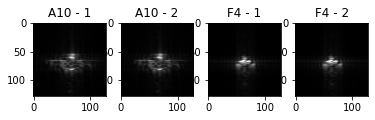

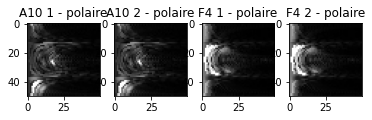

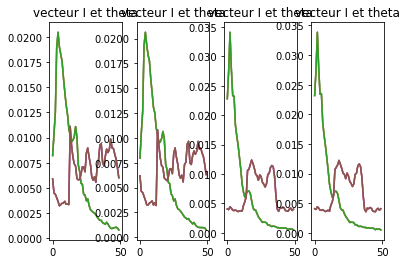

In [321]:
# Comparons Maintenant deux images d'une meme cible avec deux images d'une autre cible et etudions les vecteurs

image_cible_1_0 = cv2.imread('images_ISAR/A10_1.bmp')[64:192,64:192] 
image_cible_1_1 = cv2.imread('images_ISAR/A10_2.bmp')[64:192,64:192]

image_cible_2 = cv2.imread('images_ISAR/F4_1.bmp')[64:192,64:192]
image_cible_3 = cv2.imread('images_ISAR/F4_2.bmp')[64:192,64:192]


plt.figure()

plt.subplot(141)
plt.imshow(image_cible_1_0)
plt.title("A10 - 1")

plt.subplot(142)
plt.imshow(image_cible_1_1)
plt.title("A10 - 2")

plt.subplot(143)
plt.imshow(image_cible_2)
plt.title("F4 - 1")

plt.subplot(144)
plt.imshow(image_cible_3)
plt.title("F4 - 2")

img1_polar, I_r1, I_theta1 = polaire2(image_cible_1_0)
img2_polar, I_r2, I_theta2 = polaire2(image_cible_1_1)
img3_polar, I_r3, I_theta3 = polaire2(image_cible_2)
img4_polar, I_r4, I_theta4 = polaire2(image_cible_3)


plt.figure()

plt.subplot(141)
plt.imshow(img1_polar)
plt.title("A10 1 - polaire")

plt.subplot(142)
plt.imshow(img2_polar)
plt.title("A10 2 - polaire")

plt.subplot(143)
plt.imshow(img3_polar)
plt.title("F4 1 - polaire")

plt.subplot(144)
plt.imshow(img3_polar)
plt.title("F4 2 - polaire")

plt.figure()

plt.subplot(141)
plt.plot(I_r1)
plt.plot(I_theta1)
plt.title("vecteur I et theta")

plt.subplot(142)
plt.plot(I_r2)
plt.plot(I_theta2)
plt.title("vecteur I et theta")

plt.subplot(143)
plt.plot(I_r3)
plt.plot(I_theta3)
plt.title("vecteur I et theta")

plt.subplot(144)
plt.plot(I_r4)
plt.plot(I_theta4)
plt.title("vecteur I et theta")

plt.show()

In [322]:
image_cible_1_0 = cv2.imread("images_ISAR/A10_15.bmp")[64:192,64:192] 

image_cible_1_0_rotated = rotate(image_cible_1_0, 45) #on fait une rotation de 45 degrée

image_cible_1_0_polaire_rotated, Ir_rotated, I_theta_rotated = polaire2(image_cible_1_0_rotated) #image en polaire pour l'image en rotation

image_cible_1_0_polaire, Ir_polaire, I_theta_polaire = polaire2(image_cible_1_0) #image en polaire de l'image original


dist1 = np.linalg.norm(Ir_polaire - Ir_rotated)

dist2 = np.linalg.norm(I_theta_polaire - I_theta_rotated)

dist3 = np.linalg.norm(image_cible_1_0_polaire - image_cible_1_0_polaire_rotated)






print("Distance euclidienne entre les vecteurs et l'image polaire")
print("Distance Vecteur Ir  : ", dist1)
print("Distance Vecteur Itetha : ", dist2)
#print("Distance image : ", dist3)


Distance euclidienne entre les vecteurs et l'image polaire
Distance Vecteur Ir  :  0.010594407794007105
Distance Vecteur Itetha :  0.027848614065139006


In [323]:
image_cible_1_0 = cv2.imread("images_ISAR/A10_15.bmp")[64:192,64:192] 

image_rotated = rotate(image_cible_1_0, 90)
image_polaire = polaire(image_cible_1_0)

image_rotated_polar = polaire(image_rotated)

# la cross correlation revient a faire le produit de la transformee de Fourrier
shifts, error, phasediff = phase_cross_correlation(image_polaire, image_rotated_polar)
print(f"Translation estimée sur le vecteur Itheta pour une rotation de 90 est de {-shifts[0]} pixels")

Translation estimée sur le vecteur Itheta pour une rotation de 90 est de 12.0 pixels


## **Partie III -  Classification : reconnaissance**

In [324]:
# Fontions DecripteursBDD.py

def DecripteursBDD(path):
    X, y = load_bdd(path) 
    R_max = 50

    data = np.zeros((X.shape[0],R_max * 2))

    for i in range(X.shape[0]):
        image = X[i].reshape((128,128))                
        image_polar, Ir, I_theta = polaire2(image)  
        data[i] = np.hstack((Ir, I_theta))
        
    return {'data': data, 'labels': y}   

data = DecripteursBDD("images_ISAR/")
print(data)
print(f"La taille de cette matrice est: {(data['data'].shape)}, en ajoutant les labels, on aurait une colonne suplémentaire" )

{'data': array([[0.02465579, 0.03104034, 0.03746383, ..., 0.02357872, 0.02098338,
        0.01802468],
       [0.02956272, 0.04001661, 0.04555175, ..., 0.02678257, 0.02675741,
        0.02597746],
       [0.09376037, 0.06742449, 0.06608032, ..., 0.00794889, 0.00801527,
        0.00864587],
       ...,
       [0.02906111, 0.06991679, 0.08395118, ..., 0.00775436, 0.00754171,
        0.0098666 ],
       [0.02911684, 0.07046274, 0.08351561, ..., 0.00779763, 0.00749936,
        0.00957305],
       [0.02858817, 0.07064138, 0.0833917 , ..., 0.00776169, 0.00746151,
        0.00936263]]), 'labels': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [325]:
# Fonction reconnaissance.py

X_train, X_test, y_train, y_test = model_selection.train_test_split(data['data'], data['labels'], test_size=1/3)

print("Base d'apprentissage : ", X_train.shape, y_train.shape)
print("Base de test         : ", X_test.shape, y_test.shape)

Base d'apprentissage :  (540, 100) (540,)
Base de test         :  (270, 100) (270,)


(540, 50)
temp de calcul 0.008354902267456055 pour k=1
temp de calcul 0.005787849426269531 pour k=2
temp de calcul 0.005845785140991211 pour k=3
temp de calcul 0.01577138900756836 pour k=4
temp de calcul 0.0 pour k=5
temp de calcul 0.007174253463745117 pour k=6
temp de calcul 0.008356809616088867 pour k=7
temp de calcul 0.0 pour k=8
temp de calcul 0.0 pour k=9


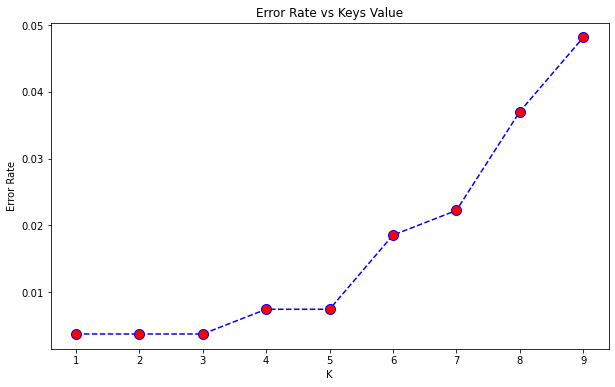


C1 Taux de classification: 0.9962962962962963

Matrice de distance :
[[0.00634856 0.01187382 0.01592607 ... 0.125865   0.12599062 0.12621326]
 [0.00315117 0.00639478 0.00674652 ... 0.14029433 0.14070471 0.14283134]
 [0.00719802 0.00869371 0.01461291 ... 0.14593901 0.14597053 0.14605093]
 ...
 [0.00660088 0.00939693 0.01126365 ... 0.18538562 0.18540247 0.18546911]
 [0.0015557  0.00263309 0.00367035 ... 0.19648435 0.19660879 0.19676155]
 [0.00231679 0.00686114 0.0077312  ... 0.13717295 0.13742042 0.13966079]] [[470 534 505 ... 135 158 285]
 [  2 230 340 ... 197 190 201]
 [409  51 133 ... 158  97 379]
 ...
 [240  24  50 ...  97 158 379]
 [379  63  97 ... 201 360 197]
 [340 496   2 ... 197 190 201]]


In [326]:

error_rate = []

print(X_train[:,:50].shape)

for i in range(1, 10):
    t_zero = time.time()
    KNN = KNeighborsClassifier(n_neighbors=i)
    KNN.fit(X_train[:,:50], y_train)
    t_end = time.time() - t_zero
    pred_i = KNN.predict(X_test[:,:50])
    error_rate.append(np.mean(pred_i != y_test))
    #print(confusion_matrix(y_test, pred_i))
    #print(classification_report(y_test, pred_i))
    print(f"temp de calcul {t_end} pour k={i}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), error_rate, color="blue", linestyle="--", marker='o', markerfacecolor='red', markersize=10)

plt.title("Error Rate vs Keys Value")
plt.xlabel('K')
plt.ylabel('Error Rate')

plt.show()


c1 = neighbors.KNeighborsClassifier(n_neighbors=1)
c1.fit(X_train[:,:50], y_train)

y_pred = c1.predict(X_test[:,:50])
print(f"\nC1 Taux de classification: {metrics.accuracy_score(y_test, y_pred)}")

matrice_distances, m_indices = c1.kneighbors(X=X_test[:,:50], n_neighbors=y_train.shape[0], return_distance=True)

print("\nMatrice de distance :")
print(matrice_distances, m_indices)

In [327]:
c1_Itheta = neighbors.KNeighborsClassifier(n_neighbors=1)
c1_Itheta.fit(X_train[:,50:], y_train)

y_pred_theta = c1_Itheta.predict(X_test[:,50:])
print(f"Lorsqu'on utilise ITheta on a comme taux de classification: {metrics.accuracy_score(y_test, y_pred_theta)}")

c1_Itheta_plus_Ir = neighbors.KNeighborsClassifier(n_neighbors=1)
c1_Itheta_plus_Ir.fit(X_train, y_train)

y_pred_Itheta_plus_Ir = c1_Itheta_plus_Ir.predict(X_test)
print(f"Lorsqu'on utilise Ir + Itetha on a comme taux de classification: {metrics.accuracy_score(y_test, y_pred_Itheta_plus_Ir)}")


Lorsqu'on utilise ITheta on a comme taux de classification: 1.0
Lorsqu'on utilise Ir + Itetha on a comme taux de classification: 1.0


In [328]:
# Implementons le classifieur C2 en utilisant la distance euclidienne comme mesure de similarite

def C2(X_train, y_train, X_test, y_test, indices, k):
    neighbors = int(0.3 * X_train.shape[0])  # On utilise que 30% percent pour ce classifieur
    y_pred = []
    indices_n = []
    
    for m in range(X_test.shape[0]):
        X_neighbors = X_train[indices[m, :neighbors]] 
        labels_neighbors = y_train[indices[m, :neighbors]]
        
        dist_neighbors = np.linalg.norm(X_neighbors-X_test[m], axis=1)
        indice_neighbors = dist_neighbors.argsort() # on retourne les indices
        k_nearest_neighbors_ids = indice_neighbors[:k]
        
        
        k_nearest_neighbors_labels = labels_neighbors[k_nearest_neighbors_ids]
        y_pred.append(scipy.stats.mode(k_nearest_neighbors_labels)[0][0])
        indices_n.append(indice_neighbors)
        
    y_pred = np.array(y_pred)
    indices_n = np.array(indices_n)
    
    return y_pred, indices_n

In [329]:

t_start = time.time()

pred_1, m_2 = C2(X_train[:,50:], y_train, X_test[:,50:], y_test, m_indices, 1)

t_1 = time.time()
print(f"Taux de classification pour k=1: {metrics.accuracy_score(y_test, pred_1)}  - Temps de calcul : {t_1-t_start}  secondes ")

pred_2, m_1 = C2(X_train[:,50:], y_train, X_test[:,50:], y_test, m_indices, 3)
t_2 = time.time()
print(f"Taux de classification pour k=3: {metrics.accuracy_score(y_test, pred_1)}  - Temps de calcul : {t_2-t_start}  secondes ")

pred_3, m_3 = C2(X_train[:,50:], y_train, X_test[:,50:], y_test, m_indices, 5)
t_3 = time.time()
print(f"Taux de classification pour k=5: {metrics.accuracy_score(y_test, pred_1)}  - Temps de calcul : {t_3-t_start}  secondes ")


Taux de classification pour k=1: 1.0  - Temps de calcul : 0.10495567321777344  secondes 
Taux de classification pour k=3: 1.0  - Temps de calcul : 0.2157883644104004  secondes 
Taux de classification pour k=5: 1.0  - Temps de calcul : 0.338334321975708  secondes 


6_mise en place de la rotation et changement d'échelle on va modifier la fonction DescripteursBBD pour y introduire la rotation et changement d'échelle pour chaque image aléatoirement

In [330]:
#on va effectuer une rotation de l'ensemble du dataset et ensuite donner les performances de bonne classification pour le c1 et c2 

def Aleatoire(path): # modifie le la fonction DescripteurBDD en effectueant une rotation et un changement d'échelle
    X, y = load_bdd(path) 
    R_max = 50

    data = np.zeros((X.shape[0],R_max * 2))

    for i in range(X.shape[0]):
        image = X[i].reshape((128,128))
        
        image_modif_1= rotate(image, np.random.randint(0,180)) #on effectue une rotation aleatoire
        image_aleatoire = rescale(image_modif_1, np.random.rand(1)*0.5+1, multichannel=True)#on fait un changement d'échelle aleatoire

        image_polar, Ir, I_theta = polaire2(image_aleatoire)  
        data[i] = np.hstack((Ir, I_theta))
        
    return {'data': data, 'labels': y}   
data1 = Aleatoire("images_ISAR")
#print(data)
#print(f"La taille de cette matrice est: {(data1['data'].shape)}, en ajoutant les labels, on aurait une colonne suplémentaire" )

Base d'apprentissage :  (540, 100) (540,)
Base de test         :  (270, 100) (270,)
(540, 50)
la matrice de confusion pour k=1 est
 [[43  1  1  9  8]
 [ 4 48  4  1  2]
 [ 3  3 42  5  2]
 [ 2  2  2 37  0]
 [ 6  1  4  0 40]]
la matrice de confusion pour k=2 est
 [[53  1  0  4  4]
 [ 6 51  2  0  0]
 [ 6  6 42  1  0]
 [ 4  3  4 32  0]
 [ 9  2  3  3 34]]
la matrice de confusion pour k=3 est
 [[48  1  0  5  8]
 [ 4 50  5  0  0]
 [ 4  6 41  4  0]
 [ 2  2  1 38  0]
 [ 6  1  4  1 39]]
la matrice de confusion pour k=4 est
 [[49  1  0  4  8]
 [ 3 51  4  0  1]
 [ 3  7 39  6  0]
 [ 2  3  3 34  1]
 [ 7  1  2  2 39]]
la matrice de confusion pour k=5 est
 [[48  2  0  4  8]
 [ 2 52  5  0  0]
 [ 3  4 44  3  1]
 [ 2  3  3 34  1]
 [ 6  1  2  2 40]]
la matrice de confusion pour k=6 est
 [[50  0  1  3  8]
 [ 2 52  5  0  0]
 [ 3  4 44  4  0]
 [ 2  5  3 32  1]
 [ 6  1  2  2 40]]
la matrice de confusion pour k=7 est
 [[51  0  1  3  7]
 [ 2 51  6  0  0]
 [ 4  4 41  5  1]
 [ 3  5  2 32  1]
 [ 6  1  2  2 40]]

C1

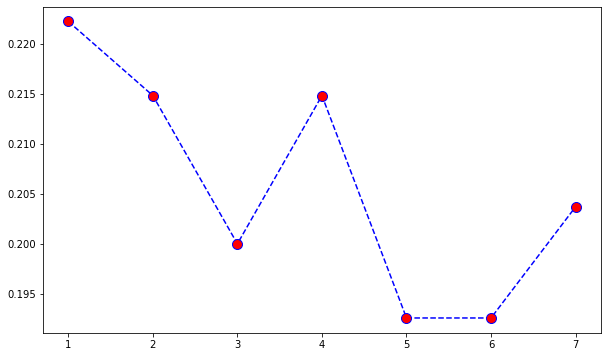

In [368]:
###############################la fonction reconnaissance.py
X_train, X_test, y_train, y_test = model_selection.train_test_split(data1['data'], data1['labels'], test_size=1/3)

print("Base d'apprentissage : ", X_train.shape, y_train.shape)
print("Base de test         : ", X_test.shape, y_test.shape)


############################################################################################## O
error_rate = []

print(X_train[:,:50].shape)

for i in range(1, 8):
    #t_zero = time.time()
    KNN = KNeighborsClassifier(n_neighbors=i)
    KNN.fit(X_train[:,:50], y_train)
    t_end = time.time() - t_zero
    pred_i = KNN.predict(X_test[:,:50])
    error_rate.append(np.mean(pred_i != y_test))
    print(f"la matrice de confusion pour k={i} est")
    print(f" {confusion_matrix(y_test, pred_i)}")
    #print(classification_report(y_test, pred_i))
    #print(f"temp de calcul {t_end} pour k={i}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, 8), error_rate, color="blue", linestyle="--", marker='o', markerfacecolor='red', markersize=10)

#plt.title("Error Rate vs Keys Value")
#plt.xlabel('K')
#plt.ylabel('Error Rate')

#plt.show()


c1 = neighbors.KNeighborsClassifier(n_neighbors=1)
c1.fit(X_train[:,:50], y_train)

y_pred = c1.predict(X_test[:,:50])
print(f"\nC1 Taux de classification: {metrics.accuracy_score(y_test, y_pred)}")

matrice_distances, m_indices = c1.kneighbors(X=X_test[:,:50], n_neighbors=y_train.shape[0], return_distance=True)

#print("\nMatrice de distance :")
#print(matrice_distances, m_indices)

In [369]:
###on effectue 
t_start = time.time()

pred_1, m_2 = C2(X_train[:,50:], y_train, X_test[:,50:], y_test, m_indices, 1)

t_1 = time.time()
print(f"Taux de classification de C2 pour k=1: {metrics.accuracy_score(y_test, pred_1)}  - Temps de calcul : {t_1-t_start}  secondes ")

pred_2, m_1 = C2(X_train[:,50:], y_train, X_test[:,50:], y_test, m_indices, 3)
t_2 = time.time()
print(f"Taux de classification pour k=3: {metrics.accuracy_score(y_test, pred_1)}  - Temps de calcul : {t_2-t_start}  secondes ")

pred_3, m_3 = C2(X_train[:,50:], y_train, X_test[:,50:], y_test, m_indices, 5)
t_3 = time.time()
print(f"Taux de classification pour k=5: {metrics.accuracy_score(y_test, pred_1)}  - Temps de calcul : {t_3-t_start}  secondes ")


Taux de classification de C2 pour k=1: 0.7555555555555555  - Temps de calcul : 0.1411142349243164  secondes 
Taux de classification pour k=3: 0.7555555555555555  - Temps de calcul : 0.24334025382995605  secondes 
Taux de classification pour k=5: 0.7555555555555555  - Temps de calcul : 0.3607609272003174  secondes 


In [377]:
data = Aleatoire("images_ISAR")


In [378]:

for i in range (5):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(data['data'], data1['labels'], test_size=1/3)

    KNN = KNeighborsClassifier(n_neighbors=1)
    KNN.fit(X_train[:,:50], y_train)
    pred_i = KNN.predict(X_test[:,:50])
    c1 = neighbors.KNeighborsClassifier(n_neighbors=1)
    c1.fit(X_train[:,:50], y_train)
    
    y_pred = c1.predict(X_test[:,:50])
    print(f"\nC1 Taux de classification pour le {i+1}ème test : {metrics.accuracy_score(y_test, y_pred)}")
    matrice_distances, m_indices = c1.kneighbors(X=X_test[:,:50], n_neighbors=y_train.shape[0], return_distance=True)

    pred_1, m_2 = C2(X_train[:,50:], y_train, X_test[:,50:], y_test, m_indices, 1)
    print(f"\nC2 Taux de classification pour le {i+1}ème test : {metrics.accuracy_score(y_test, pred_1)}")


C1 Taux de classification pour le 1ème test : 0.8

C2 Taux de classification pour le 1ème test : 0.7592592592592593

C1 Taux de classification pour le 2ème test : 0.7703703703703704

C2 Taux de classification pour le 2ème test : 0.7185185185185186

C1 Taux de classification pour le 3ème test : 0.7814814814814814

C2 Taux de classification pour le 3ème test : 0.7703703703703704

C1 Taux de classification pour le 4ème test : 0.7814814814814814

C2 Taux de classification pour le 4ème test : 0.7037037037037037

C1 Taux de classification pour le 5ème test : 0.8222222222222222

C2 Taux de classification pour le 5ème test : 0.7592592592592593


Sur les 5 simulations, généralement le taux de classifaction de C1 est légérement supérieure à celui du taux C2